In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [2]:
# equivalent of np.random.choice with numba sipport
@jit(nopython=True)
def rand_choice_nb(k, prob):
    return np.arange(k)[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

In [3]:
@jit(nopython=True)
# params: k: num of arms, alpha1: step size for updating H(a), alpha2: step size for computing average reward R_bar
def gradient_bandit(k, alpha1, alpha2, steps=1000):
    # nonstaionary environment setpup
    mean = np.random.uniform(-2, 10, k)
    cov = np.ones(k)
    
    # gradient bandit params initialization
    H = np.zeros(k)
    R_bar = 0
    Pi = np.exp(H) / np.sum(np.exp(H))
    
    # avg reward per timestep
    Rt = np.zeros(steps)
    
    # sum of rewards
    R_sum = 0
    
    # percentages of optimal actions at each time step
    opt_act = np.zeros(steps)
    
    # total number of optimal actions
    opt_act_sum = 0
    
    for i in range(steps):
        # select an action
        a = rand_choice_nb(k, Pi)
        
        # if an action is optimal action, increment optimal action counter
        if a == np.argmax(mean):
            opt_act_sum += 1
        opt_act[i] = opt_act_sum / (i + 1)
        
        # draw a reward from environment
        R = np.random.normal(mean[a], cov[a])
        
        R_sum += R
        Rt[i] = R_sum / (i + 1)
        
        # update H(a)
        for j in range(k):
            if j != a:
                H[j] -= alpha1 * (R - R_bar) * Pi[j]
        H[a] += alpha1 * (R - R_bar) * (1 - Pi[a])
        
        # update softmax distribution Pi
        Pi = np.exp(H) / np.sum(np.exp(H))
        
        # update average reward R_bar
        R_bar += alpha2 * (R - R_bar)
        
        # perturb the environment
        for j in range(k):
            mean[j] += np.random.normal(0, 1)
            
    return Rt, opt_act

## Gradient bandit in a nonstationary environment

In [4]:
%%time
steps = 10000
k = 10
rounds = 2000
alpha1 = 0.1
alpha2 = 0.1
Rt = np.zeros(steps)
Opt = np.zeros(steps)
for i in range(rounds):
    rt, opt = gradient_bandit(k, alpha1, alpha2, steps)
    Rt += rt
    Opt += opt
Rt /= rounds
Opt /= rounds

CPU times: user 23.5 s, sys: 132 ms, total: 23.7 s
Wall time: 23.8 s


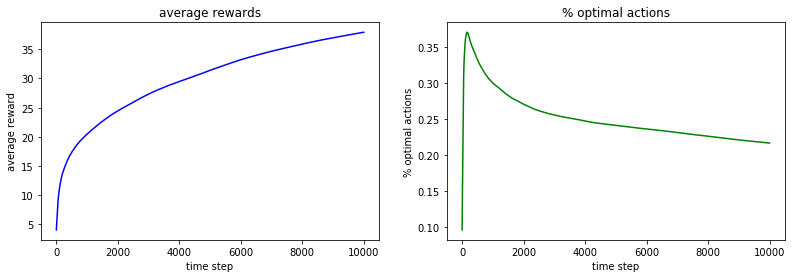

In [5]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(121)
ax.plot(Rt, "b")
plt.ylabel("average reward")
plt.xlabel("time step")
plt.title("average rewards")

ax = fig.add_subplot(122)
ax.plot(Opt, "g")
plt.ylabel("% optimal actions")
plt.xlabel("time step")
plt.title("% optimal actions")
plt.show()